In [1]:
import numpy as np
import cv2           # Image Processing Library
import matplotlib.pyplot as plt

from itertools import product
from tqdm import tqdm

# Rapport MLA Detection - PROJH402
Brenno Ferreira - 12/01/2024

## Document Synthesis 

The idea behind this notebook is to present the different edge detection tested in order to get microlens array (MLA) information. This document is also a project advancement statement.

The objective here is to find the **best calibration algorithm** responsible to information from the calibration frame (CF) such as microlens (ML) diameter and position as well as distance between adjacents ML.

Algorithm ideas were extract from the course INFOH500 - Image Acquisition & Processing and a lot of online research.

**Conclusion:**

Fourier transform masking is a great preprocessing technique and should be used alongside some blur to reduce noise. 

Best results were obtained throught the following pipeline: Fourier -> Median -> Canny -> Hough.

There is a need to explore other edge markers than Canny's and also another method than Hough Transform in order to compare and validate choices. Further researches in object detection is needed and, by now, principal leads are *region-based or border-based segmentation* in order to enhance even more the ML borders and be able to better extract position and diameter.

Parameters determination is not efficient at all. In fact, it depends on the image, size and exposure. To eliminate this problem two solutions needs to be tested:
- Improve performance by using backtracking or dynamic programming.
- Find the parameters for the ideal calibration frame and then, use another algorithm to guide users to obtain this image.

Another problem is that parameter choice is based on the maximum number of ML detected, independetly if it is regular. This means that parameters giving circles that are not at all align are alongside parameters giving regular grids of circles. There a need to filter these parameters based in the regularity of the grid but it seems very difficult and not efficient to spend time on.


## Parameters & Function Definition

## Parameters

- **Pre-Processing:**
    - **Gaussian Blur**
        - KERNEL_SIZE 
    - **Fourier Transform Masking**
        - MASK_RADIUS 

- **Processing:**
    - **Canny**
        - STRONG_EDGE_THRESHOLD
        - WEAK_EDGE_FRACTION
    - **Hough Transform**
        - DP
        - MINDIST
        - PARAM1
        - PARAM2
        - MINRADIUS
        - MAXRADIUS

In [2]:
## Image Plotting
def display_images(img_1, img_1_title, img_2, img_2_title):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(img_1, cmap='gray')
    plt.title(img_1_title)

    plt.subplot(1, 2, 2)
    plt.imshow(img_2, cmap='gray')
    plt.title(img_2_title)

    plt.show()

def draw_circles(img, circles):
    circle_img = img.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        # Draw the circles on the original image
        for i in circles:
            center = (i[0], i[1])
            diameter = i[2] * 2
            cv2.circle(circle_img, center, i[2], (0, 255, 0), 2)  # Draw the outer circle
            cv2.circle(circle_img, center, 2, (0, 0, 255), 2)  # Draw the center of the circle
    return circle_img

def print_parameters(param):
    print("Optimal Parameters: [#ML, Mask Radius, Kernel Size, Strong Edge Threshold, Weak Edge Threshold Fraction]")
    for row in param:
        print(row)

In [ ]:
## Pre-Processing Functions

def apply_gauss(img, kernel):
    return cv2.GaussianBlur(img, (kernel, kernel), 0)

def apply_median(img, kernel):
    return cv2.medianBlur(img, kernel)

def apply_fourier(img, mask_radius, invert=True, show_plot=False):
    work_img = cv2.bitwise_not(img[:,:,0]) if invert else img[:,:,0]
    
    ## Fourier Analysis
    fourier = np.fft.fft2(work_img)
    f_shift = np.fft.fftshift(fourier)
    magnitude_spectrum = np.log(np.abs(f_shift)+1)
    
    # Masking fourier
    rows, cols = work_img.shape
    max_row, max_col = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
    if mask_radius == 0:
        mask = np.ones((rows, cols), dtype=np.uint8)
    else:
        mask = np.zeros((rows, cols), dtype=np.uint8)
        cv2.circle(mask, (max_col, max_row), mask_radius, 1, thickness=-1)

    # Apply the disk mask to the Fourier Transform
    filtered_fourier = np.fft.fftshift(fourier) * mask
    filtered_magnitude_spectrum = np.log(np.abs(filtered_fourier)+1)
    # Compute the Inverse Fourier Transform
    fourier_img = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_fourier)))
    ## Display Image
    if show_plot:
        plt.figure(figsize=(40, 40))

        plt.subplot(2, 2, 1)
        plt.imshow(work_img, interpolation='none')
        plt.title("Orignal Low Exposition")

        plt.subplot(2, 2, 2)
        plt.imshow(magnitude_spectrum, interpolation='none')
        plt.title("Fourier Transform Low Exposition")

        plt.subplot(2, 2, 3)
        plt.imshow(filtered_magnitude_spectrum, interpolation='none')
        plt.title("Filtered Fourier Transform Low Exposition")

        plt.subplot(2, 2, 4)
        plt.imshow(fourier_img, cmap='gray')
        plt.title("Inverse Fourier Transform Low Exposition")

        plt.show()
        
    return cv2.cvtColor(np.uint8(fourier_img), cv2.COLOR_GRAY2RGB)

## Processing Functions

def canny_edges(img, LTHRESH, HTHRESH, alpha=.3, show_plot=False):
    edges = cv2.Canny(img, LTHRESH, HTHRESH)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    overlay = img*(1-alpha) + edges*alpha
    if show_plot:
        display_images(img, "Original PreProcessed CF", 
                       overlay, "Edges of CF")
    return overlay, edges

def sobel_edges(img, sobel_t, alpha=.3, show_plot=False):
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    edges = np.uint8(gradient_magnitude > sobel_t)
    
    edges = cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)
    overlay = img[:,:,0]*(1-alpha) + edges*alpha
    if show_plot:
        display_images(img, "Original PreProcessed CF", 
                       overlay, "Edges of CF")
    return overlay, edges

def scharr_edges(img, alpha=.3, show_plot=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    scharr_x = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
    scharr_y = cv2.Scharr(gray, cv2.CV_64F, 0, 1)
    # Combine Scharr results
    edges = np.sqrt(scharr_x**2 + scharr_y**2)
    edges = np.uint8(edges)
    
    overlay = gray*(1-alpha) + edges*alpha
    if show_plot:
        display_images(img, "Original PreProcessed CF", 
                       overlay, "Edges of CF")
    return overlay, edges

def prewitt_edges(img, prewitt_t, alpha=.3, show_plot=False):
    prewitt_x = cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]))
    prewitt_y = cv2.filter2D(img, cv2.CV_64F, np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]))
    gradient_magnitude = np.sqrt(prewitt_x**2 + prewitt_y**2)
    edges = np.uint8(gradient_magnitude > prewitt_t)
    
    edges = cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)
    overlay = img[:,:,0]*(1-alpha) + edges*alpha
    if show_plot:
        display_images(img, "Original PreProcessed CF", 
                       overlay, "Edges of CF")
    return overlay, edges

def detect_circles(img, dp, minDist, param1, param2, minRadius, maxRadius): 
    circles = cv2.HoughCircles(
        img,
        cv2.HOUGH_GRADIENT,
        dp=dp, 
        minDist=minDist, 
        param1=param1,
        param2=param2,
        minRadius=minRadius,
        maxRadius=maxRadius) 
    if circles is not None:
        circles = np.uint16(np.around(circles))
        return sort_circles(circles[0,:])
    else:
        return [[0, 0, 0]]

## Helper Function

def sort_circles(circles_array):
    sort_idy = np.argsort(circles_array[:, 1])
    sort_idx = np.argsort(circles_array[:,0])
    circle_sorted = circles_array[sort_idy]
    return circle_sorted[sort_idx]

## Information Extraction Function

def mean_distance(circles_array, axis):
    # DO NOT WORK AS WANTED
    unique = np.unique(circles_array[:, 0])
    diff_dist = [unique[i+1]-unique[i] for i in range(len(unique)-1)][1:-1]
    return np.mean(diff_dist)

def average_diameter(circles_array):
    return np.mean(circles_array[:, 2]*2)

def number_ML_per_axis(circles_array, axis):
    tolerance = 15
    axis_values = circles_array[:, axis]
    unique_coords, counts = np.unique(np.round(axis_values / tolerance), return_counts=True)
    return np.max(counts)

def get_properties(circles_array, print_prop=False):
    nb_microlens = len(circles_array)
    mean_diameter = average_diameter(circles_array)
    mean_dist_x = mean_distance(circles_array, 0)
    mean_dist_y = mean_distance(circles_array, 1)
    ml_per_x = number_ML_per_axis(circles_array, 0)
    ml_per_y = number_ML_per_axis(circles_array, 1)
    circle_ref = min(circles_array, key=lambda circle: (circle[0], circle[1]))
    cx_ref = circle_ref[0]
    cy_ref = circle_ref[1]
    if print_prop:
        print(f"Number of Microlens detected: {nb_microlens}")
        print(f"Average Diameter: {mean_diameter}")
        print(f"Average Distance X: {mean_dist_x}")
        print(f"Average Distance Y: {mean_dist_y}")
        print(f"ML per x axis: {ml_per_x}")
        print(f"ML per y axis: {ml_per_y}")
    return nb_microlens, mean_diameter, mean_dist_x, mean_dist_y, ml_per_x, ml_per_y, cx_ref, cy_ref


### Parameter Determination Functions

These are functions that does exhaustive search in order to detect the paramater combination that results in the most circles detected. It is not a optimal solution but it is better to manually check parameters. It should be optimized before implemented into real software.

In [ ]:
def exhaustive_run(img, canny=False, gauss=False, median=False, fourier=False, f_inverse=True, sobel=False, prewitt=False, scharr=False):
    # Fourier Mask Parameters
    row = img.shape[0]
    mask_range = [i for i in range(int(row*0.05),int(row*0.10))] if fourier else [1]
    # Gaussian Blur Parameters
    kernel_range = [5, 7, 9, 11] if gauss or median else [1]
    # Canny Edges Parameters
    STRONG_EDGE_range = [i for i in range(13, 17)] if canny else [1]
    WEAK_EDGE_range = [.5]  #[.3, .5, .7] if canny else [1]
    # Sobel Parameter
    SOBEL_range = [i for i in range(13, 17)] if sobel else [1]
    # Prewitt Parameter
    Prewitt_range = [i for i in range(13, 17)] if prewitt else [1]
    

    circles_img = img.copy()
    
    optimal_param = [(0,0,0,0,0,0,0)]

    for mask, kernel, strong, weak, sobel_t, prewitt_t in tqdm(product(mask_range, 
                                                                       kernel_range,
                                                                       STRONG_EDGE_range,
                                                                       WEAK_EDGE_range,
                                                                       SOBEL_range,
                                                                       Prewitt_range),
                                    desc="Processing items", unit="item"):
        work_img = circles_img
        
        ### Pre Processing
        ## Fourier
        if fourier:
            work_img = apply_fourier(work_img, mask, invert=f_inverse)
        ## Gauss
        if gauss:
            work_img = apply_gauss(work_img, kernel)
        # Median
        if median:
            work_img = apply_median(work_img, kernel)
        
        ### Edges Marker

        ## Sobel
        if sobel:
            _, work_img = sobel_edges(work_img, sobel_t)
        ## Prewitt 
        if prewitt:
            _, work_img = prewitt_edges(work_img, prewitt_t)
        ## Scharr
        if scharr:
            _, work_img = scharr_edges(work_img)
        ## Canny
        if canny:
            _, work_img = canny_edges(work_img, weak*strong, strong, alpha=.3, show_plot=False)
        ### Circle Detection
        ## Hough
        circles = detect_circles(work_img, 1, 30, strong, 1, 16, 18)

        nb_ml = len(circles)
        max_ml = optimal_param[0][0]
        if nb_ml > max_ml and nb_ml > 1:
            optimal_param = [(nb_ml, mask, kernel, strong, weak, sobel_t, prewitt_t)]
        elif nb_ml == max_ml and nb_ml > 1:
            optimal_param.append((nb_ml, mask, kernel, strong, weak, sobel_t, prewitt_t))
        
    return optimal_param

## Calibration Frame (CF)

**Calibration frame** are manually adjusted and captured by the user. Correctness of calibration values depends on how well exposed the calibration frame is. Indeed, the more constrated are the ML, the better the algorithm can segment it from the image. This is done by adjusting aperture of the camera.

The first image test is a low exposed calibration frame. As explained later, this is the better image to calibration because it is possible, even visually, to recognize the MLA. 

~~However, in order to test the algorithm is a smaller image, a sample was taken from it. This sample consists in a single ML at the center of the original image. It is possible to recognize one center ML and eight halfs of ML.~~

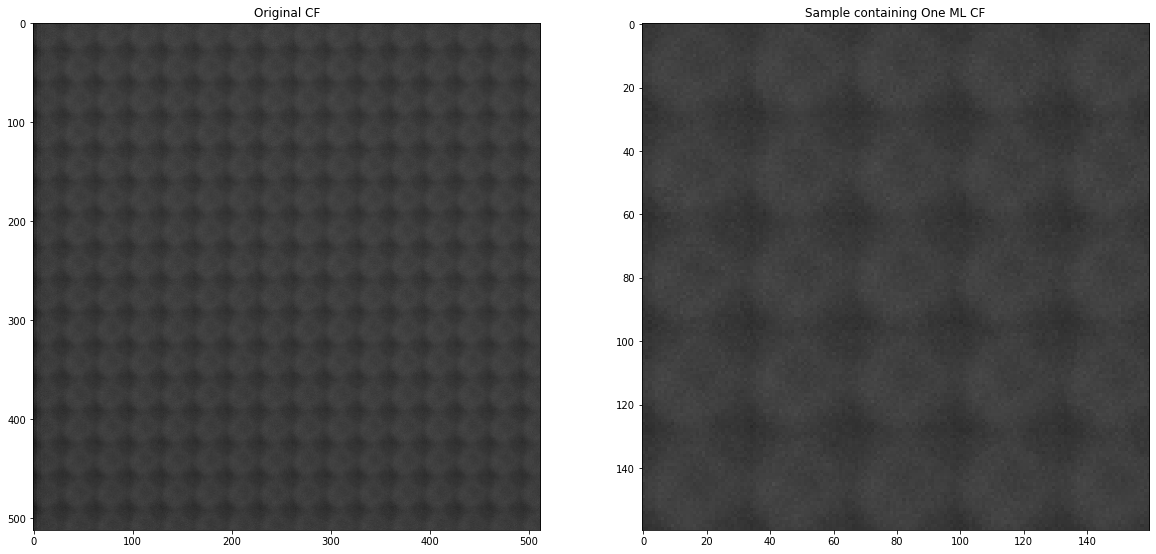

In [31]:
original_low = cv2.imread("../img/nice_mla_cercles_low.png")
sample_low = original_low[32:192, 228:388,:]

display_images(original_low, "Original CF", sample_low, "Sample containing One ML CF")

It is possible to estimate values from both CF:

| Properties | Value |
| :--- | :---: |
| ML Diameter | 36 |
| ML distance | 36 |
| #ML on x | 16 |
| #ML on y | 16 |
| Total #ML | 256|

This values are going to be used to compare results.

### Results


In [ ]:
working_img = original_low # You can switch to small image and big image by changing the working_im

# Fourier Gauss Canny Hough

parameters = exhaustive_run(working_img, gauss=True, median=False, fourier=True, f_inverse=True, canny=True)
print(f"{len(parameters)} optimal parameters found.")
nb_ml, mask, kernel, strong, weak, sobel_t, prewitt_t = parameters[0]

print("#ML:{} Mask Radius:{} Kernel Size:{} Strong Threshold:{} Weak Threshold:{} Sobel Threshold:{} Prewitt Threshold:{}"
      .format(nb_ml, mask, kernel, strong, weak, sobel_t, prewitt_t))

## Fourier
fourier_sample = apply_fourier(working_img, mask, invert=True, show_plot=True)
## Gauss
blur_sample = apply_gauss(fourier_sample, kernel)
## Canny
overlay_sample, fourier_sample_edge = canny_edges(blur_sample, weak*strong, strong, alpha=.3, show_plot=True)
## Hough
circles_sample = detect_circles(fourier_sample_edge, 1, 30, strong, 1, 16, 18)

## Display images
circles_sample_img = draw_circles(working_img, circles_sample)
display_images(~working_img, "Sample CF", circles_sample_img, "Circles in Sample CF")
top_five = circles_sample[:5]
for circle in top_five:
    print(circle)
get_properties(circles_sample, True)

In [ ]:
# Fourier Median Canny Hough

parameters = exhaustive_run(working_img, gauss=False, median=True, fourier=True, f_inverse=True, canny=True)
print(f"{len(parameters)} optimal parameters found.")
nb_ml, mask, kernel, strong, weak, sobel_t, prewitt_t = parameters[0]
print(nb_ml, mask, kernel, strong, weak, sobel_t, prewitt_t)

## Fourier
fourier_sample = apply_fourier(working_img, mask, invert=True, show_plot=True)
## Median
blur_sample = apply_median(fourier_sample, kernel)
## Canny
overlay_sample, fourier_sample_edge = canny_edges(blur_sample, weak*strong, strong, alpha=.3, show_plot=True)
## Hough
circles_sample = detect_circles(fourier_sample_edge, 1, 30, strong, 1, 16, 18)

## Display images
circles_sample_img = draw_circles(working_img, circles_sample)
display_images(working_img, "Sample CF", circles_sample_img, "Circles in Sample CF")
top_five = circles_sample[:5]
for circle in top_five:
    print(circle)
get_properties(circles_sample, True)

In [ ]:
# Fourier Median Sobel Hough

parameters = exhaustive_run(working_img, gauss=False, median=True, fourier=True, f_inverse=True, canny=False, sobel=True)
print(f"{len(parameters)} optimal parameters found.")
nb_ml, mask, kernel, strong, weak, sobel_t, prewitt_t = parameters[0]
print(nb_ml, mask, kernel, strong, weak, sobel_t, prewitt_t)

## Fourier
fourier_sample = apply_fourier(working_img, mask, invert=True, show_plot=True)
## Median
blur_sample = apply_median(fourier_sample, kernel)
## Sobel Edges
_, sample_edge = sobel_edges(blur_sample, sobel_t, show_plot=True)
## Hough
circles_sample = detect_circles(sample_edge, 1, 30, strong, 1, 16, 18)

## Display images
circles_sample_img = draw_circles(working_img, circles_sample)
display_images(working_img, "Sample CF", circles_sample_img, "Circles in Sample CF")
top_five = circles_sample[:5]
for circle in top_five:
    print(circle)
get_properties(circles_sample, True)

In [ ]:
# Fourier Gauss Prewitt Hough

parameters = exhaustive_run(working_img, gauss=True, median=False, fourier=True, f_inverse=True, canny=False, sobel=False, prewitt=True)
print(f"{len(parameters)} optimal parameters found.")
nb_ml, mask, kernel, strong, weak, sobel_t, prewitt_t = parameters[0]
print(nb_ml, mask, kernel, strong, weak, sobel_t, prewitt_t)

## Fourier
fourier_sample = apply_fourier(working_img, mask, invert=True, show_plot=True)
## Gauss
blur_sample = apply_gauss(fourier_sample, kernel)
## Prewitt Edges
_, sample_edge = prewitt_edges(blur_sample, prewitt_t, show_plot=True)
## Hough
circles_sample = detect_circles(sample_edge, 1, 30, strong, 1, 16, 18)

## Display images
circles_sample_img = draw_circles(working_img, circles_sample)
display_images(working_img, "Sample CF", circles_sample_img, "Circles in Sample CF")
top_five = circles_sample[:5]
for circle in top_five:
    print(circle)
get_properties(circles_sample, True)

In [ ]:
# Fourier Gauss Scharr Hough

parameters = exhaustive_run(working_img, gauss=True, median=False, fourier=True, f_inverse=True, canny=False, sobel=False, prewitt=False, scharr=True)
print(f"{len(parameters)} optimal parameters found.")
nb_ml, mask, kernel, strong, weak, sobel_t, prewitt_t = parameters[0]
print(nb_ml, mask, kernel, strong, weak, sobel_t, prewitt_t)

## Fourier
fourier_sample = apply_fourier(working_img, mask, invert=True, show_plot=True)
## Gauss
blur_sample = apply_gauss(fourier_sample, kernel)
## Scharr Edges
_, sample_edge = scharr_edges(blur_sample, show_plot=True)
## Hough
circles_sample = detect_circles(sample_edge, 1, 30, strong, 1, 16, 18)

## Display images
circles_sample_img = draw_circles(working_img, circles_sample)
display_images(working_img, "Sample CF", circles_sample_img, "Circles in Sample CF")
top_five = circles_sample[:5]
for circle in top_five:
    print(circle)
get_properties(circles_sample, True)

## New Approach

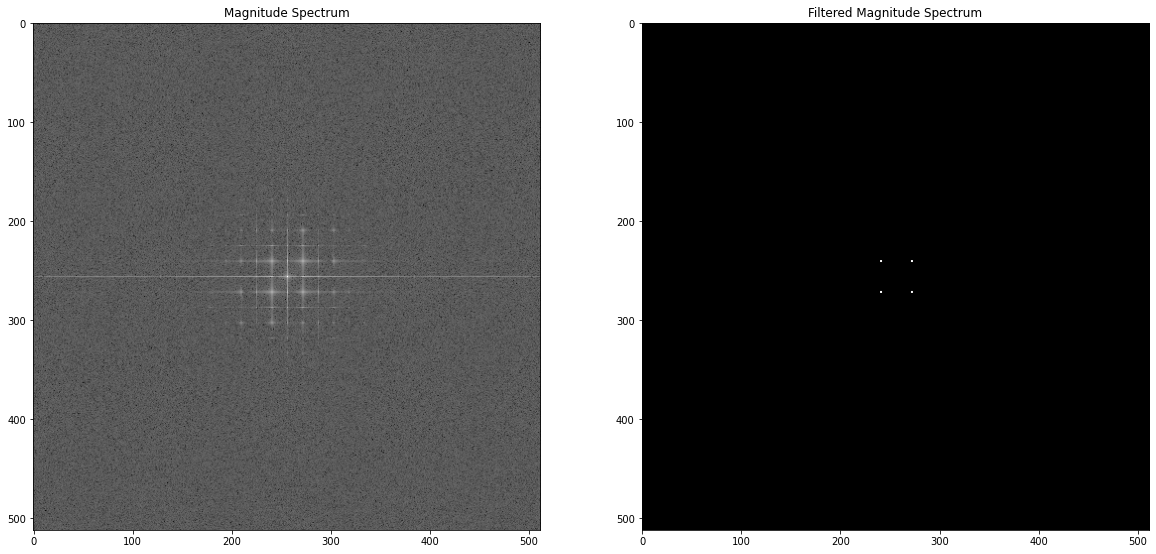

Points: [(240, 240), (240, 241), (240, 271), (240, 272), (241, 240), (241, 241), (241, 271), (241, 272), (271, 240), (271, 241), (271, 271), (271, 272), (272, 240), (272, 241), (272, 271), (272, 272)]
Average Distance: 32.68184902739809
Peaks X: [240 240 240 240 241 241 241 241 271 271 271 271 272 272 272 272]
Peaks Y: [240 241 271 272 240 241 271 272 240 241 271 272 240 241 271 272]
Grid Spacing X:  32.68184902739809
Grid Spacing Y:  32.68184902739809


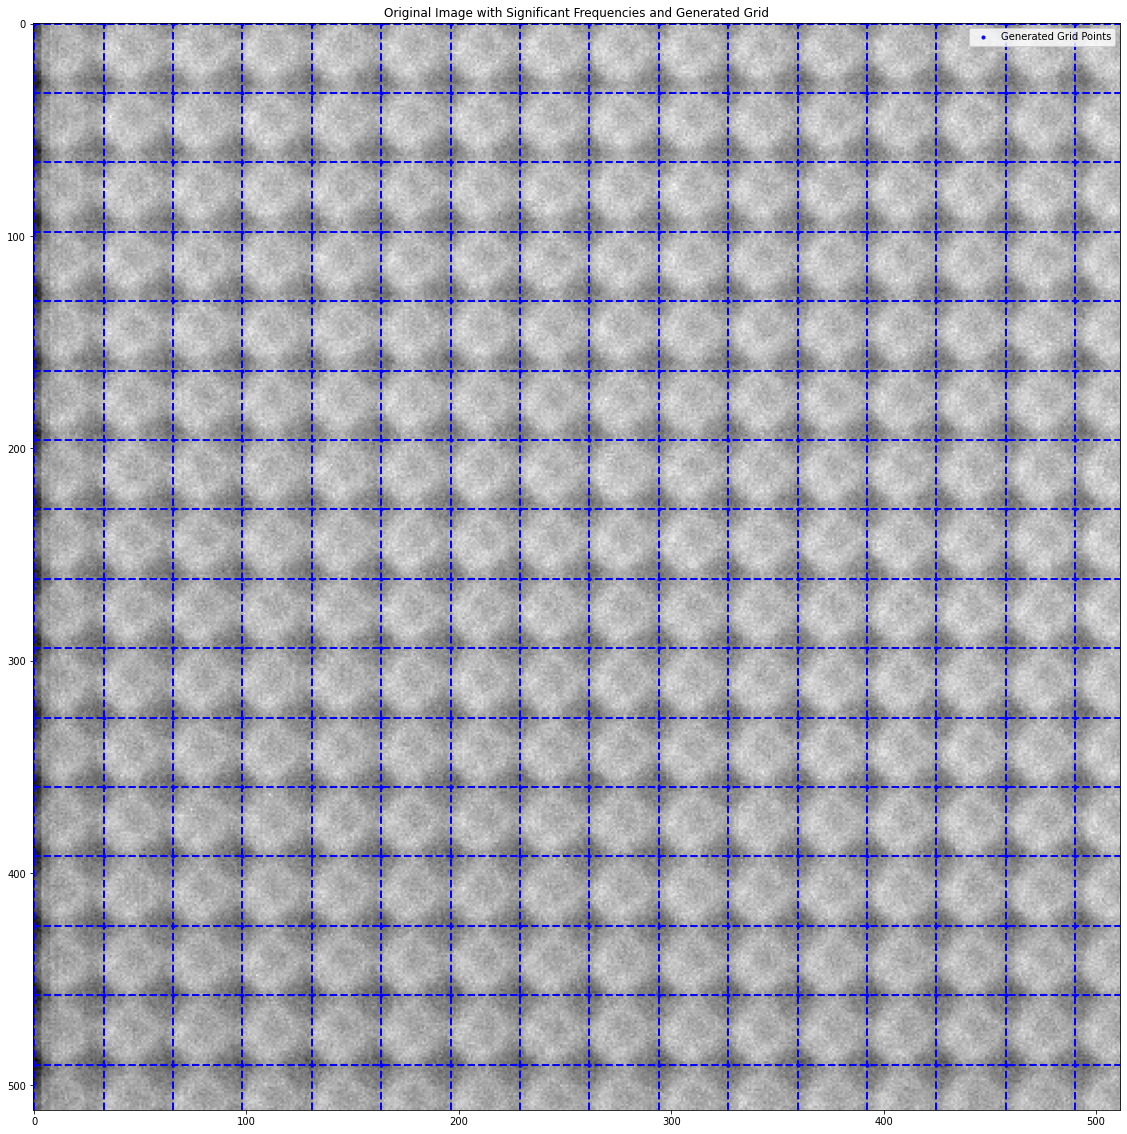

In [67]:
#https://imagej.nih.narkive.com/lPbPtXIM/detecting-grid-size-by-using-the-fft
#https://www.mathworks.com/matlabcentral/answers/764431-how-to-detect-a-thick-grid-in-an-image
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

working_img = original_low[:,:,0]
rows, cols = working_img.shape[:2]

## Fourier Analysis
fourier = np.fft.fft2(working_img)
f_shift = np.fft.fftshift(fourier)
# Get Peaks of Fourier Transform
magnitude_spectrum = np.log(np.abs(f_shift)+1)
threshold = np.max(magnitude_spectrum)*0.672 #0.672
filtered_magnitude = np.where(magnitude_spectrum > threshold, magnitude_spectrum, 0) 
size = 2
c_row, c_col = magnitude_spectrum.shape[0]//2, magnitude_spectrum.shape[1]//2
filtered_magnitude[:, c_row-size:c_row+size] = 0
filtered_magnitude[:, c_row-size:c_row+size] = 0
filtered_magnitude[c_col-size:c_col+size, :] = 0
filtered_magnitude[c_col-size:c_col+size, :] = 0
filtered_fourier = f_shift*filtered_magnitude
filtered_img = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_fourier)))
display_images(magnitude_spectrum, 'Magnitude Spectrum', filtered_magnitude, 'Filtered Magnitude Spectrum')

## APPROACH 1:
peaks_x, peaks_y = np.where(filtered_magnitude)
points = [i for i in zip(peaks_x, peaks_y)]
distances = []
for i in range(len(points)):
    for j in range(i + 1, len(points)):
        distances.append(euclidean_distance(points[i], points[j]))
distances = [dist for dist in distances if dist > 1]
# Calculate the average distance
average_distance = np.mean(distances)
grid_spacing_x = average_distance
grid_spacing_y = average_distance

##APPROACH 2:
## Calculate the x and y coordinates of the significant frequencies
#peaks_x, peaks_y = np.where(filtered_magnitude)
#points = [i for i in zip(peaks_x, peaks_y)]
## Calculate pairwise distances for both x and y directions
#distances_x = []
#distances_y = []
#for i in range(len(points)):
#    for j in range(i + 1, len(points)):
#        distances_x.append(abs(points[i][0] - points[j][0]))
#        distances_y.append(abs(points[i][1] - points[j][1]))
## Filter out distances greater than 1
#distances_x = [dist for dist in distances_x if dist > 1]
#distances_y = [dist for dist in distances_y if dist > 1]
## Calculate the average distances for x and y
#average_distance_x = np.mean(distances_x)
#average_distance_y = np.mean(distances_y)
## Calculate grid spacings for x and y
#grid_spacing_x = average_distance_x
#grid_spacing_y = average_distance_y

print("Points:", points)
print("Average Distance:", average_distance)
print("Peaks X:", peaks_x)
print("Peaks Y:", peaks_y)
print("Grid Spacing X: ", grid_spacing_x)
print("Grid Spacing Y: ", grid_spacing_y)
# Generate regular grid
x_grid = np.arange(0, cols, grid_spacing_x)
y_grid = np.arange(0, rows, grid_spacing_y)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
# Visualize the original image with the generated grid
plt.figure(figsize=(20, 20))

plt.imshow(working_img, cmap='gray')
plt.scatter(x_grid, y_grid, c='blue', marker='.', label='Generated Grid Points')
# Plot grid lines
for x_line in x_grid[0, :]:
    plt.axvline(x=x_line, color='b', linestyle='--', linewidth=2)

for y_line in y_grid[:,0]:
    plt.axhline(y=y_line, color='b', linestyle='--', linewidth=2)

plt.title('Original Image with Significant Frequencies and Generated Grid')
plt.legend()
plt.show()